## Image classification following Keras example

Ideas come from [here](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

## Path and names

In [1]:
train_PATH = '../data/dog_cat/dog_cat_original/train/'
valid_PATH = '../data/dog_cat/dog_cat_original/test/'
name = 'dog_vs_cat_balaced'

## Libraries

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

import matplotlib.pyplot as plt

import pickle

import numpy as np

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, auc

Using TensorFlow backend.


## Convolution and pooling layers

In [3]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

## Fully connected layer

In [4]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Compile the model

In [5]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Load dataset

In [6]:
batch_size = 16

In [7]:
# training with augmentation 
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# test only rescale
validation_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
        train_PATH,  
        target_size=(150, 150),  
        batch_size=batch_size,
        class_mode='binary')  

# validation set is not shuffled
validation_generator = validation_datagen.flow_from_directory(
        valid_PATH,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 2000 images belonging to 2 classes.
Found 802 images belonging to 2 classes.


In [9]:
train_size = len(train_generator.filenames)
validation_size = len(validation_generator.filenames)

## Fitting the model

In [10]:
model.fit_generator(
        train_generator,
        steps_per_epoch= train_size // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps= validation_size // batch_size)

Epoch 1/50
125/125 [==============================] - 147s 1s/step - loss: 0.7325 - accuracy: 0.5125 - val_loss: 0.4836 - val_accuracy: 0.4988
Epoch 2/50
125/125 [==============================] - 137s 1s/step - loss: 0.6803 - accuracy: 0.5845 - val_loss: 0.7422 - val_accuracy: 0.6247
Epoch 3/50
125/125 [==============================] - 136s 1s/step - loss: 0.6405 - accuracy: 0.6250 - val_loss: 0.6179 - val_accuracy: 0.7023
Epoch 4/50
125/125 [==============================] - 137s 1s/step - loss: 0.6265 - accuracy: 0.6550 - val_loss: 0.7136 - val_accuracy: 0.7023
Epoch 5/50
125/125 [==============================] - 137s 1s/step - loss: 0.6064 - accuracy: 0.6855 - val_loss: 0.6040 - val_accuracy: 0.7010
Epoch 6/50
125/125 [==============================] - 138s 1s/step - loss: 0.5884 - accuracy: 0.6920 - val_loss: 1.0508 - val_accuracy: 0.7341
Epoch 7/50
125/125 [==============================] - 137s 1s/step - loss: 0.5596 - accuracy: 0.7215 - val_loss: 0.4502 - val_accuracy: 0.6756

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)       

## Save the model

In [12]:
#model arch and weigths 
model.save(f'{name}_model.h5') 

#history dictionary
with open(f'{name}_history.dict', 'wb') as file_pi:
        pickle.dump(model.history.history, file_pi)

## Training evaluation

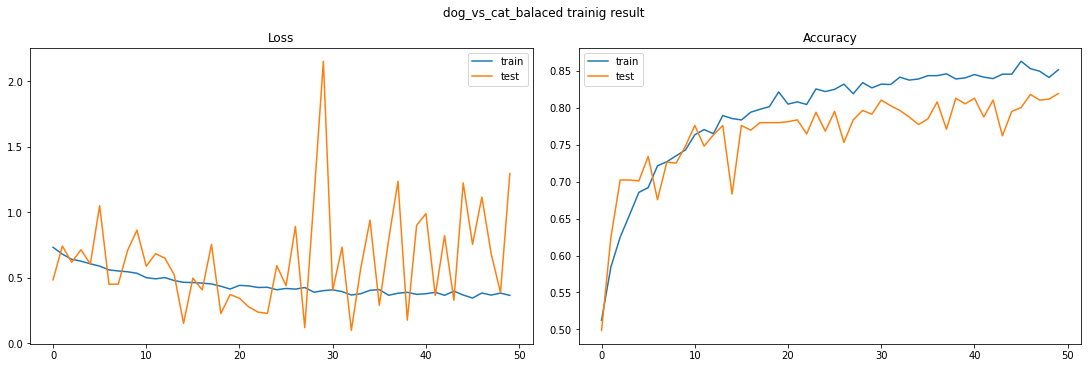

In [13]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,5), constrained_layout=True,)

_ = fig.suptitle(f'{name} trainig result')

_ = ax1.set_title('Loss')
_ = ax1.plot(model.history.history['loss'], label='train')
_ = ax1.plot(model.history.history['val_loss'], label='test')
_ = ax1.legend()

_ = ax2.set_title('Accuracy')
_ = ax2.plot(model.history.history['accuracy'], label='train')
_ = ax2.plot(model.history.history['val_accuracy'], label='test')
_ = ax2.legend()

plt.savefig(f'{name}_trainig_result.png')

## Predictions and metrics

In [14]:
def convert_to_binary(y):
    pred_class = []
    pred_prob = []
    
    for i in range(len(y)):
        pred_prob.append(y[i][0])
                   
        if y[i][0]>=0.5:
            pred_class.append(1)
        else:
            pred_class.append(0)
            
    return np.asarray(pred_class), np.asarray(pred_prob)

In [15]:
#real
y_real = validation_generator.classes

#predicted
test_pred_prob = model.predict(validation_generator)
y_pred_class, y_pred_prob = convert_to_binary(test_pred_prob)

In [16]:
y_real

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
y_pred_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [18]:
precision = precision_score(y_real, y_pred_class)
recall = recall_score(y_real, y_pred_class)

fpr_th, tpr_th, _ = roc_curve(y_real, y_pred_prob)
AUC_ROC = auc(fpr_th, tpr_th)

precision_th, recall_th, _ = precision_recall_curve(y_real, y_pred_prob)
PR_AUC = auc(recall_th, precision_th)

In [19]:
print ('Precision =',precision)
print ('Recall =',recall)
print ('Area under ROC curve =',AUC_ROC)
print ('Area under precision-Recall curve =',PR_AUC)

Precision = 0.8018867924528302
Recall = 0.8478802992518704
Area under ROC curve = 0.8687135030254787
Area under precision-Recall curve = 0.857981171513511


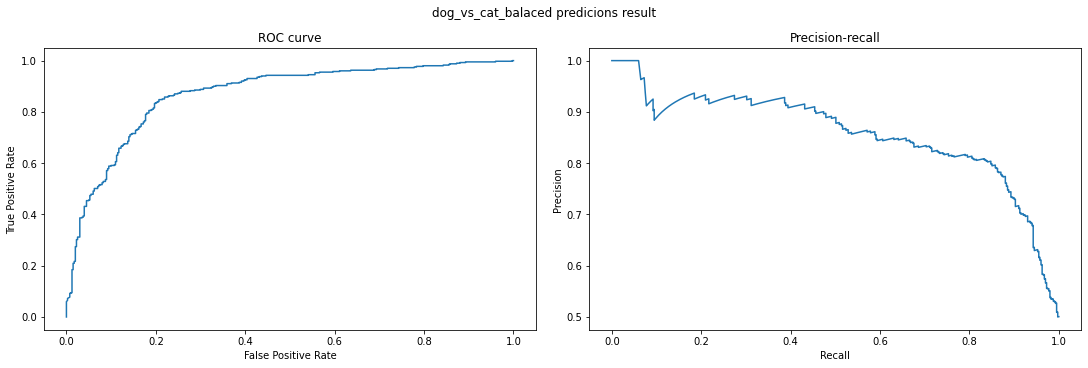

In [20]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,5), constrained_layout=True,)

_ = fig.suptitle(f'{name} predicions result')

_ = ax1.set_title('ROC curve')
_ = ax1.plot(fpr_th, tpr_th)
_ = ax1.set_xlabel('False Positive Rate')
_ = ax1.set_ylabel('True Positive Rate')


_ = ax2.set_title('Precision-recall')
_ = ax2.plot(recall_th, precision_th)
_ = ax2.set_xlabel('Recall')
_ = ax2.set_ylabel('Precision')


plt.savefig(f'{name}_predictions_result.png')